In [1]:
from __future__ import division, print_function
from sys import platform as _platform
import matplotlib

if _platform == "linux" or _platform == "linux2":
    matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pylab as plt
import os
import sys
import numpy as np
import random
import copy
import traceback
import operator
from collections import defaultdict
from pprint import pprint
import string
from graph_tool.all import *
import scipy.stats as stats
from IPython.display import HTML
import pandas as pd
import sys
import os
lib_path = '/home/fgeigl/'
print('append', lib_path)
sys.path.append(lib_path)
import tools.mpl_tools as plt_tools
# import seaborn
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['xtick.major.pad'] *= 2
matplotlib.rcParams['ytick.major.pad'] *= 2
import pprint

append /home/fgeigl/


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def matrix_to_latex(mat, decimals=2):
    print(r'\begin{pmatrix}')
    try:    
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                if j != 0:
                    print(' & ', end='')
                print(np.round(mat[i,j], decimals=decimals), end='')
            if i != mat.shape[0] - 1:
                print(r' \\')
            else:
                print('')
    except:
        for i in range(mat.shape[0]):
            print(np.round(mat[i], decimals=decimals), end='')
            if i != mat.shape[0] - 1:
                print(r' \\')
            else:
                print('')
    print(r'\end{pmatrix}')
    
def trans_mat(mat):
    # print('get trans mat of\n', mat)
    out = np.array(mat.sum(axis=0)).flatten()
    # print('Matrix outdegree\n', out)

    D = np.diag(out)
    # print('D\n', D)

    # print(np.power(D,-1))
    D_norm = np.power(D, -1)
    D_norm[np.invert(np.isfinite(D_norm))] = 0

    return mat.dot(D_norm)
    

/usr/lib/python2.7/dist-packages/graph_tool/draw/cairo_draw.py:619: UserWarning: Unknown parameter: C
  warnings.warn("Unknown parameter: " + k, UserWarning)


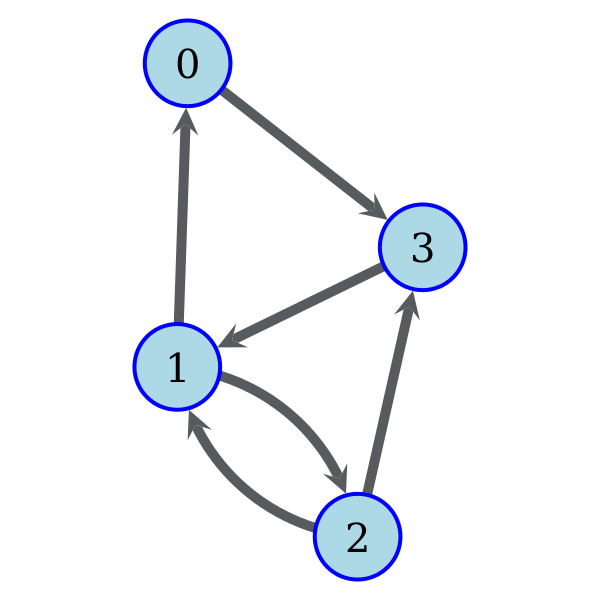

In [3]:
g = Graph(directed=True)
vertices = g.add_vertex(4)
g.add_edge(1, 0)
g.add_edge(0, 3)
g.add_edge(2, 3)
# g.add_edge(3, 0)
g.add_edge(3, 1)
g.add_edge(1, 2)
g.add_edge(2, 1)

label_names = g.new_vertex_property('string')
for v in g.vertices():
    label_names[v] = str(v)
graph_draw(g, vertex_text=label_names, vertex_font_size= 40, vertex_pen_width=4, vertex_color='blue', vertex_fill_color='lightblue', edge_pen_width=10, C=0.01, output='toy_graph.pdf')
target_nodes = [0]

# defaults

In [4]:
A = adjacency(g).todense()
print('A\n', A)

t = np.zeros(A.shape[0])
t[target_nodes] = 1
print('t\n', t)

A_out = np.array(A.sum(axis=0)).flatten()
print('A outdegree\n', A_out)

D = np.diag(A_out)
print('D\n', D)

# print(np.power(D,-1))
D_norm = np.power(D, -1)
D_norm[np.invert(np.isfinite(D_norm))] = 0

P = A.dot(D_norm)
print('P\n', P)
def get_stat_dist(P):
    w, v = np.linalg.eig(P)
    w = w.real
    v = v.real
    max_eig = np.argmax(w)
    print('max eig:', w[max_eig])
    pi = np.array(v[:, max_eig]).flatten()
    pi /= pi.sum()
    print('pi\n', pi, '\npi sum', pi.sum())
    print('pi = P * pi:', np.allclose(pi, np.array(P.dot(pi)).flatten()))
    return pi
pi = get_stat_dist(P)
matrix_to_latex(pi)

A
 [[ 0.  1.  0.  0.]
 [ 0.  0.  1.  1.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  1.  0.]]
t
 [ 1.  0.  0.  0.]
A outdegree
 [ 1.  2.  2.  1.]
D
 [[ 1.  0.  0.  0.]
 [ 0.  2.  0.  0.]
 [ 0.  0.  2.  0.]
 [ 0.  0.  0.  1.]]
P
 [[ 0.   0.5  0.   0. ]
 [ 0.   0.   0.5  1. ]
 [ 0.   0.5  0.   0. ]
 [ 1.   0.   0.5  0. ]]
max eig: 1.0
pi
 [ 0.18181818  0.36363636  0.18181818  0.27272727] 
pi sum 1.0
pi = P * pi: True
\begin{pmatrix}
0.18 \\
0.36 \\
0.18 \\
0.27
\end{pmatrix}


# bias

In [5]:
N = np.diag(t)
print('N\n', N)

W_B = A + N.dot(A)
print('W_B\n', W_B)



N
 [[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
W_B
 [[ 0.  2.  0.  0.]
 [ 0.  0.  1.  1.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  1.  0.]]


# link inseration

In [6]:
print('A\n', A)
print('t\n', t)
links_to_t = np.where(A[t==1, :] < 1)
print('links to t:', links_to_t)
links = filter(lambda x: x[0] != x[1], zip(links_to_t[0],links_to_t[1]))
print('links\n', links)
num_links = int(W_B.sum() - A.sum())
print('num links:', num_links)
links = links[num_links:]
print('ins links:', links)
A_LI = A.copy()
for i,j in links:
    A_LI[i,j] += 1
print('A_LI\n', A_LI)

A
 [[ 0.  1.  0.  0.]
 [ 0.  0.  1.  1.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  1.  0.]]
t
 [ 1.  0.  0.  0.]
links to t: (array([0, 0, 0]), array([0, 2, 3]))
links
 [(0, 2), (0, 3)]
num links: 1
ins links: [(0, 3)]
A_LI
 [[ 0.  1.  0.  1.]
 [ 0.  0.  1.  1.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  1.  0.]]


In [7]:
matrix_to_latex(A.astype('int'))

\begin{pmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 1 \\
0 & 1 & 0 & 0 \\
1 & 0 & 1 & 0
\end{pmatrix}


In [8]:
matrix_to_latex(t.astype('int'))

\begin{pmatrix}
1 \\
0 \\
0 \\
0
\end{pmatrix}


In [9]:
matrix_to_latex(D.astype('int'))
matrix_to_latex(P)

\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 2 & 0 & 0 \\
0 & 0 & 2 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
0.0 & 0.5 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.5 & 1.0 \\
0.0 & 0.5 & 0.0 & 0.0 \\
1.0 & 0.0 & 0.5 & 0.0
\end{pmatrix}


In [10]:
matrix_to_latex(N.astype('int'))
matrix_to_latex(W_B.astype('int'))
matrix_to_latex(trans_mat(W_B))
matrix_to_latex(get_stat_dist(trans_mat(W_B)))

\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}
\begin{pmatrix}
0 & 2 & 0 & 0 \\
0 & 0 & 1 & 1 \\
0 & 1 & 0 & 0 \\
1 & 0 & 1 & 0
\end{pmatrix}
\begin{pmatrix}
0.0 & 0.67 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.5 & 1.0 \\
0.0 & 0.33 & 0.0 & 0.0 \\
1.0 & 0.0 & 0.5 & 0.0
\end{pmatrix}
max eig: 1.0
pi
 [ 0.23529412  0.35294118  0.11764706  0.29411765] 
pi sum 1.0
pi = P * pi: True
\begin{pmatrix}
0.24 \\
0.35 \\
0.12 \\
0.29
\end{pmatrix}


In [11]:
matrix_to_latex(A_LI.astype('int'))
matrix_to_latex(trans_mat(A_LI))
matrix_to_latex(get_stat_dist(trans_mat(A_LI)))

\begin{pmatrix}
0 & 1 & 0 & 1 \\
0 & 0 & 1 & 1 \\
0 & 1 & 0 & 0 \\
1 & 0 & 1 & 0
\end{pmatrix}
\begin{pmatrix}
0.0 & 0.5 & 0.0 & 0.5 \\
0.0 & 0.0 & 0.5 & 0.5 \\
0.0 & 0.5 & 0.0 & 0.0 \\
1.0 & 0.0 & 0.5 & 0.0
\end{pmatrix}
max eig: 1.0
pi
 [ 0.29411765  0.23529412  0.11764706  0.35294118] 
pi sum 1.0
pi = P * pi: True
\begin{pmatrix}
0.29 \\
0.24 \\
0.12 \\
0.35
\end{pmatrix}
